In [1]:
!git clone https://github.com/cipher982/marketing-mix-modeling.git
!cp marketing-mix-modeling/funcs.py funcs.py

Cloning into 'marketing-mix-modeling'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 32 (delta 9), reused 24 (delta 5), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
# get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

sns.color_palette("husl")
sns.set_style('darkgrid')

import pystan
import os
import json
import funcs

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
DATA_DIR = 'marketing-mix-modeling/data/'

In [6]:
# Load measured data
m_df = pd.read_csv(DATA_DIR+"measured_ad_channel_data.csv")
m_df = m_df[m_df["channel"] != "Congrats  YOU FOUND ME!!!!"]

# extract weekly dates
m_df = funcs.add_week_start(m_df, 'day')

# get weekly media impressions
m_imp = m_df.groupby(["wk_strt_dt","channel"]).sum()['impressions'].reset_index()
m_imp = m_imp.pivot(index='wk_strt_dt', columns=['channel'], values=['impressions'])
m_imp = m_imp.droplevel(axis=1, level=0).reset_index()
m_imp = m_imp.fillna(value=0)
#m_imp.head(3)

# get weekly media spend
m_sp = m_df.groupby(["wk_strt_dt","channel"]).sum()['spend'].reset_index()
m_sp = m_sp.pivot(index='wk_strt_dt', columns=['channel'], values=['spend'])
m_sp = m_sp.droplevel(axis=1, level=0).reset_index()
m_sp = m_sp.fillna(value=0)
#m_sp.head(3)

# Get weekly sales
sales = pd.read_csv(DATA_DIR+"order_data.csv.gzip", compression="gzip")
sales['date'] = pd.to_datetime(sales['ORDER_DATE'])
sales['weekday'] = sales['date'].dt.weekday
sales["wk_strt_dt"] = sales['date'] - sales['weekday'] * timedelta(days=1)
sales = pd.DataFrame(sales.groupby(["wk_strt_dt"]).sum()['PRODUCT_SUBTOTAL'])
sales.columns = ['sales']

# Get Facebook data
fb = pd.read_csv(DATA_DIR+"collaborative_ad_data.csv")
fb = funcs.add_week_start(fb, "DATE")
fb = pd.DataFrame(fb.groupby(["wk_strt_dt"])['SPEND','IMPRESSIONS'].sum())
fb.columns = ['Facebook_spnd','Facebook_imps']

# Get TV data
tv = pd.read_csv(DATA_DIR+"tv_spend.csv")
tv.fillna(0, inplace=True)
tv = funcs.add_week_start(tv, 'date')
tv['tv_imps'] = tv['spend'] / tv['cost per view']
tv = pd.DataFrame(tv.groupby(['wk_strt_dt'])['tv_imps','spend'].sum())
tv.columns = ['tv_imps', 'tv_spnd']

# Create holiday data
dr = pd.date_range(start=sales.index.min(), end=sales.index.max())
hldy_df = pd.DataFrame()
hldy_df['date'] = dr

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
hldy_df['holiday'] = hldy_df['date'].isin(holidays)

hldy_df = funcs.add_week_start(hldy_df, 'date')
hldy_df = pd.DataFrame(hldy_df.groupby(["wk_strt_dt"]).any()['holiday'])
hldy_df = hldy_df.astype(int)
print("Loaded all datasets.")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Loaded all datasets.


In [8]:
# Merge all data
df = pd.merge(m_imp, m_sp, on='wk_strt_dt', suffixes=('_imps','_spnd'))
df = pd.merge(df, hldy_df, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, sales, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, fb, left_on='wk_strt_dt', right_index=True)
df = pd.merge(df, tv, left_on='wk_strt_dt', right_index=True, how='left')

# set placeholder for seasonality
df['seasonality'] = 1.0 

# ensure no 0s in the data (bugs like them)
df.fillna(value=0.0, inplace=True)
df = df.replace(to_replace=0.0, value=1.0) 

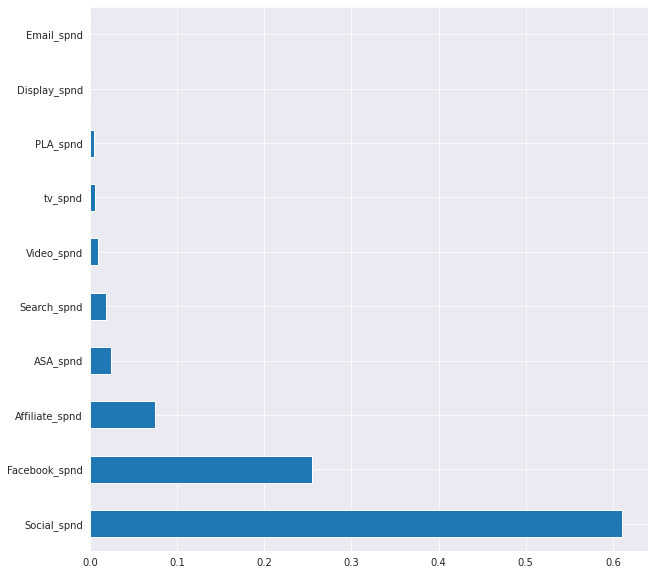

In [9]:
sp_cols = [col for col in df.columns if '_spnd' in col]
spend_df = df[sp_cols + ['sales']]

# Setting X and y variables
X = spend_df.loc[:, spend_df.columns != 'sales']
y = spend_df['sales']
# Building Random Forest model

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=.25, 
    random_state=0
)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Visualizing Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))